### Load Data

In [5]:
from tensorflow import keras

# Path of the 'Images' directory
images_dir = './archive/images/Images/'
anotations_dir = './archive/annotations/Annotation/'

# Load the dataset using this keras function to get the images and labels
stanford_ds = keras.preprocessing.image_dataset_from_directory('archive/images/Images/')

Found 20580 files belonging to 120 classes.


In [26]:
# Getting consecutive batches of 32 images a nd labels as we call next on the iterator
data_iterator  = stanford_ds.as_numpy_iterator()
batch = data_iterator.next()

# batch[0] is the images and batch[1] is the labels
print("Batch images and Labels", len(batch))
print("Batch images shape", batch[0].shape)
print("Batch iabels shape", batch[1].shape)

Batch images and Labels 2
Batch images shape (32, 256, 256, 3)
Batch iabels shape (32,)


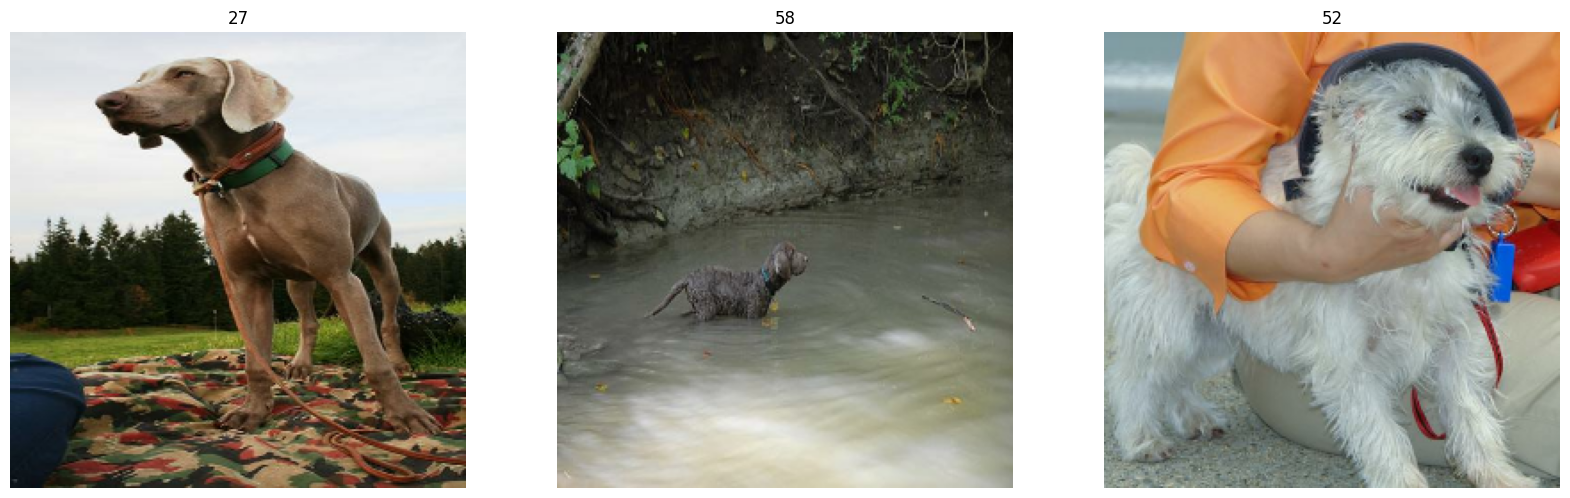

In [27]:
from matplotlib import pyplot as plt

fig,ax = plt.subplots(ncols=3, figsize=(20,10))
for i, img in enumerate(batch[0][:3]):
    ax[i].imshow(img.astype(int))
    ax[i].set_title(batch[1][i])
    ax[i].axis('off')

# Preprocessing the data

In [49]:
# In the preprocessing step, we will normalize the pixel values to be between 0 and 1 instead of 0 and 255, this allows the model to learn faster and produce better results
# We will also split our dataset into training, testing and validation sets to avoid overfitting

# Transform the dataset to get the images and labels
data = stanford_ds.map(lambda x, y: (x/255.0, y))
batch = data.as_numpy_iterator().next()

# Verify that the pixel values are between 0 and 1
batch[0].max(), batch[0].min()

(1.0, 0.0)

In [70]:
# Split the dataset into training, validation and test sets
# The train data is going to be used to train the deep learning model
train_set = int(0.7 * len(data))
# Evaluate the model while training 
val_set = int(0.2 * len(data)) + 1
# Test is used to evaluate the model after training
test_set = int(0.1 * len(data)) + 1

# Print the sizes of the resulting sets
print(len(data), train_set, val_set, test_set)
train_set+val_set+test_set == len(data)

644 450 129 65


True

In [72]:
# Take defines how many elements to take from the dataset
# Skip defines how many elements to skip from the dataset

train = data.take(train_set)
val = data.skip(train_set).take(val_set) 
test = data.skip(train_set+val_set).take(test_set)

len(train), len(val), len(test) 

(450, 129, 65)

In [77]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

# Dense layers are fully connected layers
# Conv2D layers are convolutional layers for images
# MaxPooling2D layers are pooling layers that condense the images checking the maximum value in a window of pixels and keeping that value
# Dense layers are fully connected layers
# Flatten layers flatten the input to a 1D array to be fed into the dense layers
# Dropout layers randomly drop some of the connections between layers to avoid overfitting

# Create a sequential model
model = Sequential()

# Add layers to the model
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 16)       

In [78]:
hist = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10


2023-12-09 20:14:33.465665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


450/450 [==============================] - 42s 88ms/step - loss: 0.0000e+00 - accuracy: 0.0092 - val_loss: 0.0000e+00 - val_accuracy: 0.0094
Epoch 2/10
450/450 [==============================] - 42s 93ms/step - loss: 0.0000e+00 - accuracy: 0.0091 - val_loss: 0.0000e+00 - val_accuracy: 0.0090
Epoch 3/10
450/450 [==============================] - 45s 100ms/step - loss: 0.0000e+00 - accuracy: 0.0091 - val_loss: 0.0000e+00 - val_accuracy: 0.0097
Epoch 4/10
450/450 [==============================] - 38s 85ms/step - loss: 0.0000e+00 - accuracy: 0.0092 - val_loss: 0.0000e+00 - val_accuracy: 0.0090
Epoch 5/10
450/450 [==============================] - 38s 84ms/step - loss: 0.0000e+00 - accuracy: 0.0091 - val_loss: 0.0000e+00 - val_accuracy: 0.0090
Epoch 6/10
450/450 [==============================] - 40s 89ms/step - loss: 0.0000e+00 - accuracy: 0.0090 - val_loss: 0.0000e+00 - val_accuracy: 0.0087
Epoch 7/10
450/450 [==============================] - 36s 79ms/step - loss: 0.0000e+00 - accuracy: